Bring in raw CMP data and convert it to clean hourly, daily, monthly time series

In [2]:
import pandas as pd
import csv
from datetime import datetime

timestamp = []
kwh = []

with open("./UsageData-01_01_2022-11_26_2024.csv", "r") as file:
    reader = csv.reader(file)
    for row in reader:
        time = datetime.strptime(row[3], '%m/%d/%Y %I:%M:%S %p')
        timestamp.append(time)
        kwh.append(float(row[5]))

cmp_hourly_usage = pd.DataFrame(data=kwh, index=timestamp, columns=["kwh"])
cmp_hourly_usage.index.name = "timestamp"

In [4]:
# Brings in weather observation data nearest to cmp dataset location
import meteostat

latitude = 44.06
longitude = -69.8
radius_miles = 50

all_stations = meteostat.Stations()
stations = all_stations.nearby(
    lat= latitude,
    lon= longitude,
    radius= (1609.344*radius_miles)
).fetch()


stations = stations[(stations["hourly_start"] <= cmp_hourly_usage.index.min()) & (stations["hourly_end"] >= cmp_hourly_usage.index.max())]
station = stations["distance"].idxmin()

observations = meteostat.Hourly(
    loc = station,
    start= cmp_hourly_usage.index.min(),
    end= cmp_hourly_usage.index.max()
).fetch()

observations = cmp_hourly_usage.join(observations, how="inner")

# Compute wind chill
# T_wc = 13.12 + 0.6215 * T_a * (0.3965 * T_a - 11.37) * v^0.16
observations["wchill"] = 13.12 + (0.6215*observations["temp"]) - (11.37*observations["wspd"]**0.16) + (0.3965*observations["temp"]*observations["wspd"]**.16)

observations.to_csv("./observations.csv")

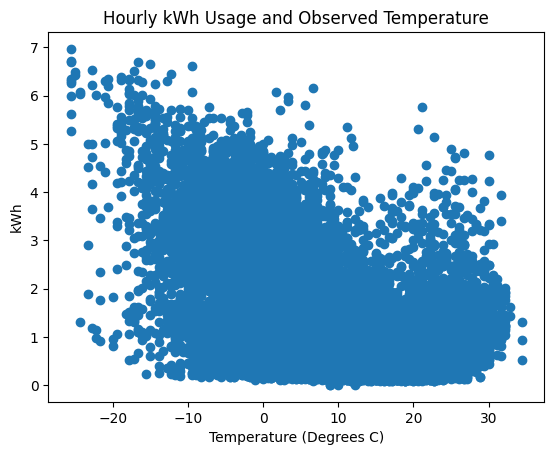

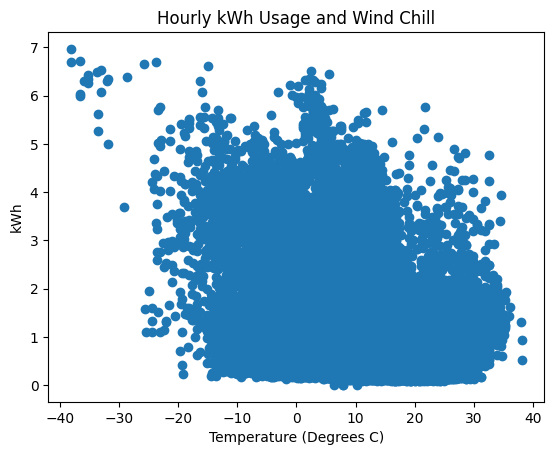

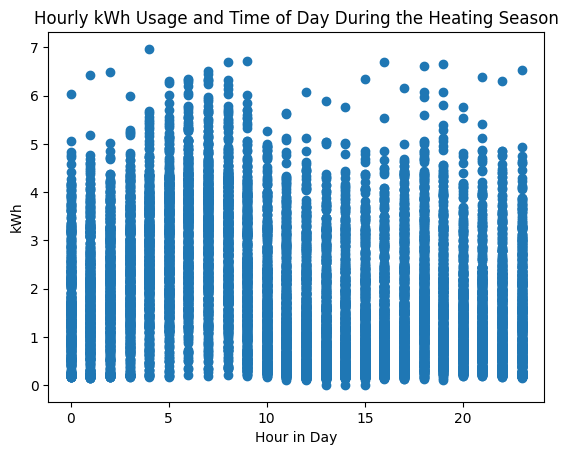

In [5]:
import matplotlib.pyplot as plt

hourly_observations = pd.read_csv("./observations.csv", index_col=0)
plt.scatter(hourly_observations["temp"], hourly_observations["kwh"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Hourly kWh Usage and Observed Temperature")
plt.show()

plt.scatter(hourly_observations["wchill"], hourly_observations["kwh"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Hourly kWh Usage and Wind Chill")
plt.show()

hourly_observations["hour"] = [datetime.strptime(dtime, '%Y-%m-%d %H:%M:%S').hour for dtime in hourly_observations.index.to_numpy()]
hourly_observations["month"] = [datetime.strptime(dtime, '%Y-%m-%d %H:%M:%S').month for dtime in hourly_observations.index.to_numpy()]

heating_season = hourly_observations[hourly_observations["month"].isin([1,2,3,4,11,12])]
plt.scatter(heating_season["hour"], heating_season["kwh"])
plt.xlabel("Hour in Day")
plt.ylabel("kWh")
plt.title("Hourly kWh Usage and Time of Day During the Heating Season")
plt.show()

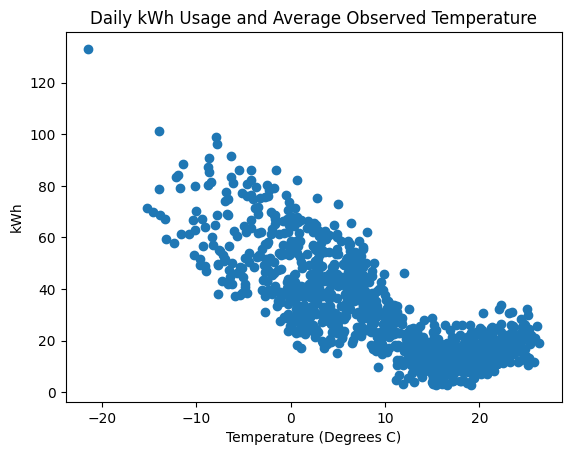

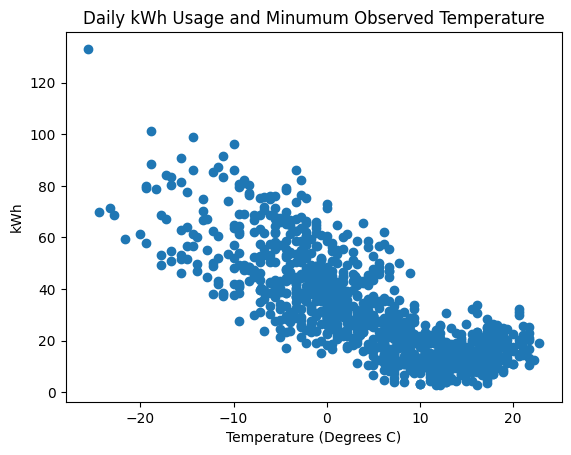

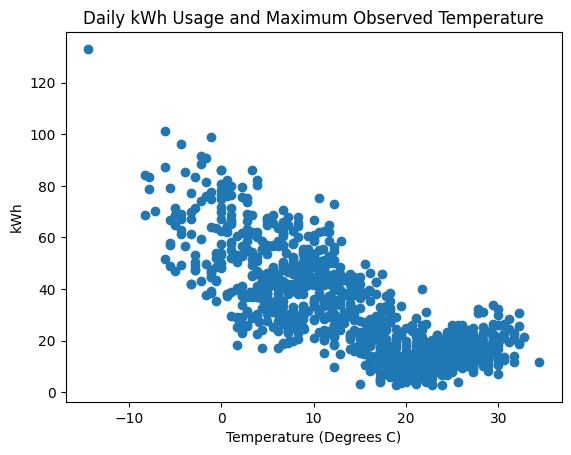

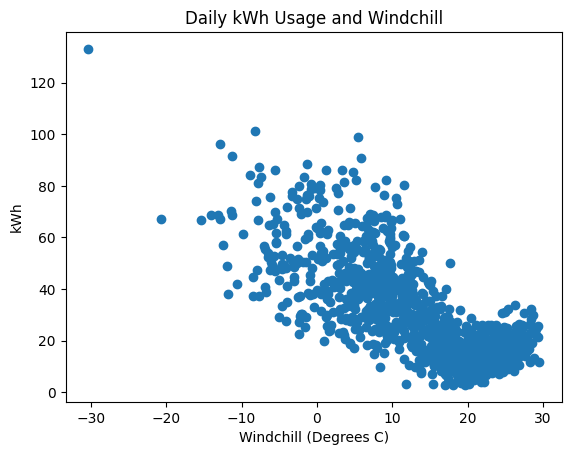

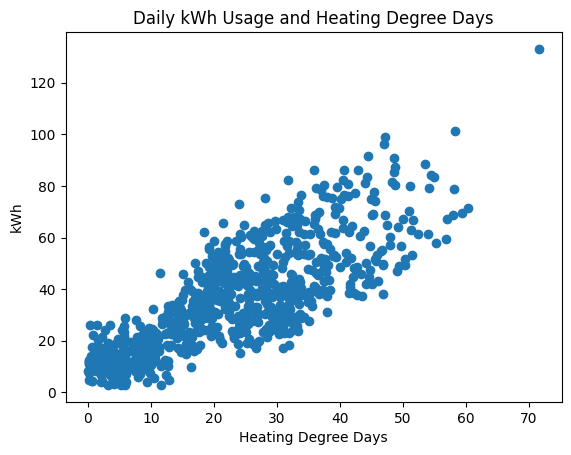

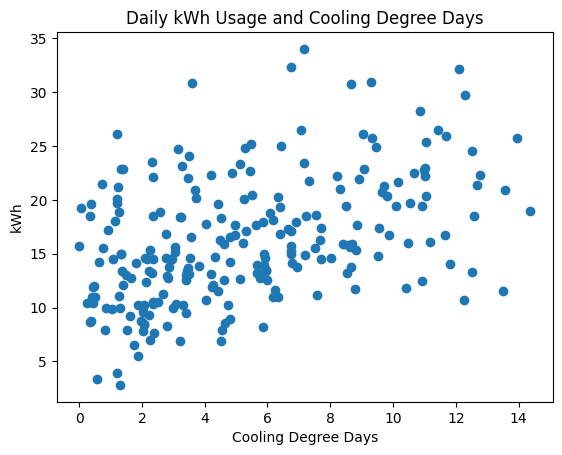

In [ ]:
import matplotlib.pyplot as plt

hourly_observations = pd.read_csv("./observations.csv", index_col=0, parse_dates=True)
daily_observations = hourly_observations.resample('D').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"],
        "wspd": ["mean"],
        "wchill": ["mean"]
    }
)

daily_observations.to_csv("./daily_observations.csv")

plt.scatter(daily_observations["temp"]["mean"], daily_observations["kwh"]["sum"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Average Observed Temperature")
plt.show()

plt.scatter(daily_observations["temp"]["min"], daily_observations["kwh"]["sum"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Minumum Observed Temperature")
plt.show()

plt.scatter(daily_observations["temp"]["max"], daily_observations["kwh"]["sum"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Maximum Observed Temperature")
plt.show()

plt.scatter(daily_observations["wchill"]["mean"], daily_observations["kwh"]["sum"])
plt.xlabel("Windchill (Degrees C)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Windchill")
plt.show()


# Heating and cooling degree days
import numpy as np
daily_observations["mean_f"] = daily_observations["temp"]["mean"]*1.8 + 32.

daily_observations["hdd"] = np.where(daily_observations["mean_f"]  <=65., 65. - daily_observations["mean_f"], None)
daily_observations["cdd"] = np.where(daily_observations["mean_f"]  >=65., daily_observations["mean_f"] - 65., None)

plt.scatter(daily_observations["hdd"], daily_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Heating Degree Days")
plt.show()

plt.scatter(daily_observations["cdd"], daily_observations["kwh"]["sum"])
plt.xlabel("Cooling Degree Days")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Cooling Degree Days")
plt.show()



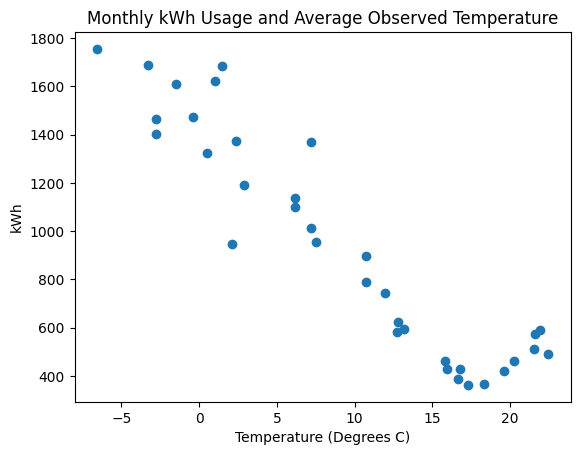

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

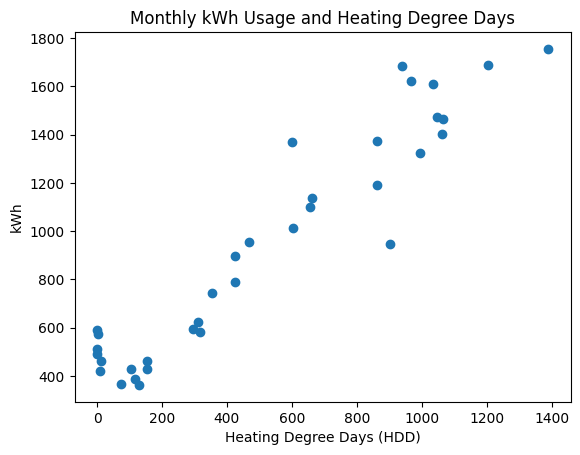

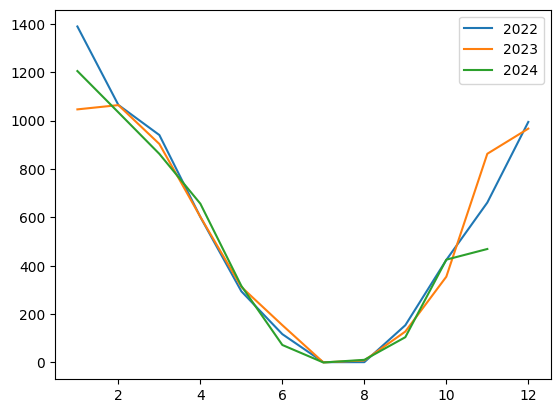

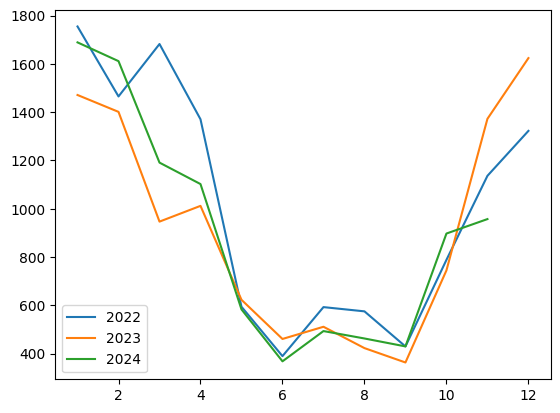

In [47]:
import matplotlib.pyplot as plt

hourly_observations = pd.read_csv("./observations.csv", index_col=0, parse_dates=True)
monthly_observations = hourly_observations.resample('M').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)

plt.scatter(monthly_observations["temp"]["mean"], monthly_observations["kwh"]["sum"])
plt.xlabel("Temperature (Degrees C)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Average Observed Temperature")
plt.show()

# Heating degree days
import numpy as np
from datetime import timedelta
hdd = []
for date in monthly_observations.index:
    month = date.month
    daily_timestamps = [datetime(date.year, date.month, 1) + timedelta(days=i) for i in range(date.day)]
    data = daily_observations[daily_observations.index.isin(daily_timestamps)]
    data["temp_f"] = data["temp"]["mean"]*1.8 + 32.
    hdd.append(
            np.sum(np.where(data["mean_f"]  <=65., 65. - data["mean_f"], 0.))
    )
monthly_observations["hdd"] = hdd
monthly_observations["hdd"] = monthly_observations["hdd"]
monthly_observations.to_csv("./monthly_observations.csv")

plt.scatter(monthly_observations["hdd"], monthly_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Heating Degree Days")
plt.show()

# Seasonality
years = range(
    np.min([date.year for date in monthly_observations.index]),
    np.max([date.year for date in monthly_observations.index]) + 1
)
annualized_data = []
for year in years:
    monthly_stamps = [datetime(year, i, 1) - timedelta(days=1) for i in range(2,13)] + [datetime(year,12,31)]
    annualized_data.append(
        monthly_observations[monthly_observations.index.isin(monthly_stamps)]
    
    )

# Plot HDD
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["hdd"], label=years[i])
    plt.legend()
plt.show()

# Plot KWh
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["kwh"], label=years[i])
    plt.legend()
plt.show()

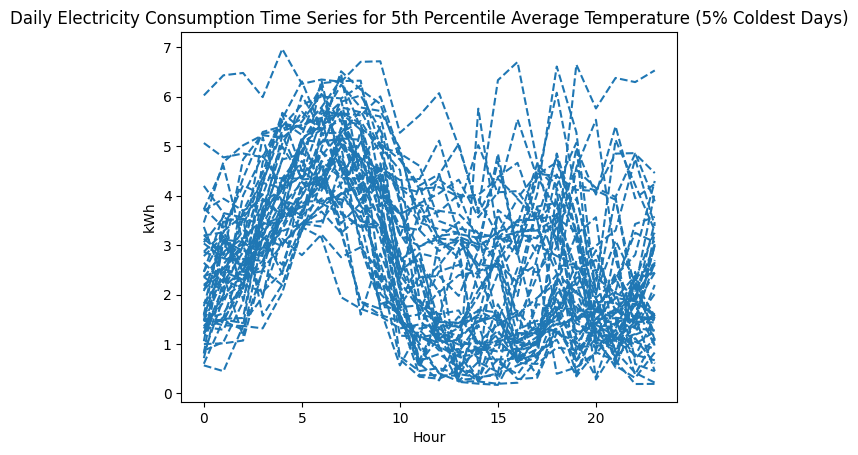

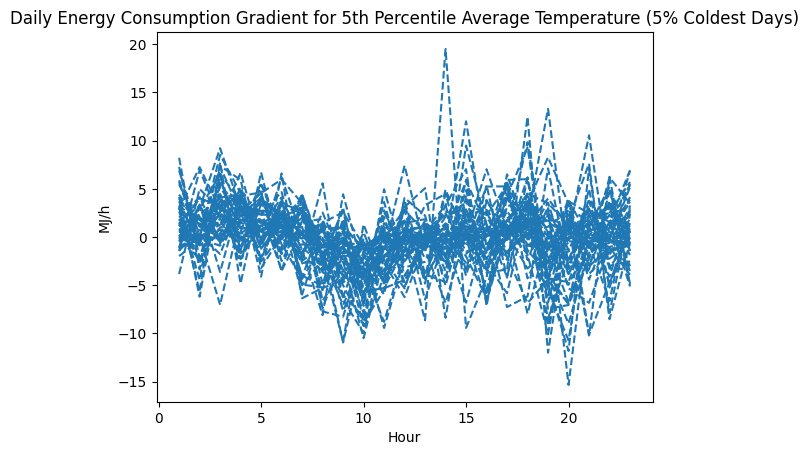

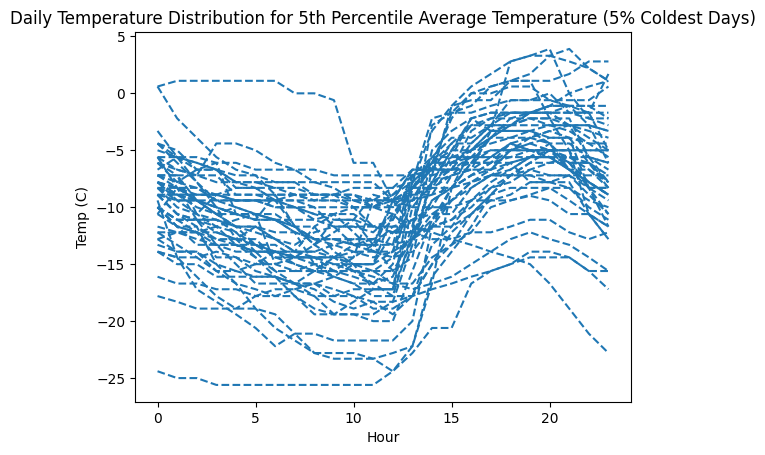

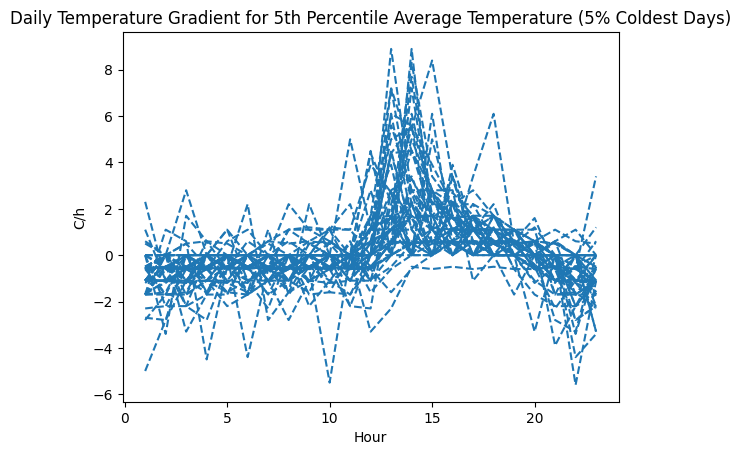

In [ ]:
# What do the coldest days have in common?
threshold = daily_observations["temp"]["mean"].quantile(.05,interpolation='linear')
coldest_days = daily_observations[daily_observations["temp"]["mean"] <= threshold]
  
# What do the daily distributions look like?
from datetime import timedelta
new_observations = []
data = []
for day in coldest_days.index:
    hourly_timestamps = [day + timedelta(hours=i) for i in range(24)]
    data.append(
        hourly_observations[hourly_observations.index.isin(hourly_timestamps)]
    )
    
# Electricty Consumption distribution
for day in data:  
    plt.plot([timestamp.hour for timestamp in day.index], day["kwh"], linestyle="--", color="tab:blue")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.title("Electricity Consumption on Coldest Days (5th percentile)")
plt.show()

# Energy Consumption Gradient
for day in data:
    mj = day["kwh"]*3.6 #megajoules
    mj_h = mj.diff(periods=1).to_list()
    plt.plot([timestamp.hour for timestamp in day.index], mj_h, linestyle="--", color="tab:blue")
    plt.xlabel("Hour")
    plt.ylabel("MJ/h")
    plt.title("Rate of Energy Consumption on Coldest Days (5th percentile)")
plt.show()

# Temp Distribtuion
for day in data:  
    plt.plot([timestamp.hour for timestamp in day.index], day["temp"], linestyle="--", color="tab:blue")
    plt.xlabel("Hour")
    plt.ylabel("Temp (C)")
    plt.title("Temperature on Coldest Days (5th percentile)")
plt.show()

# Temp Gradient (backward difference)
for day in data:
    temp_gradient = day["temp"].diff(periods=1).to_list()
    plt.plot([timestamp.hour for timestamp in day.index], temp_gradient, linestyle="--", color="tab:blue")
    plt.xlabel("Hour")
    plt.ylabel("C/h")
    plt.title("Rate of Temperature Change on Coldest Days (5th percentile)")
plt.show()
